In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Import dataset
data = pd.read_csv("/kaggle/input/newforecast/output.csv")
data.head()

,Unnamed: 0,adAverage,adChange,adClose,adHigh,adLow,adOpen,average,basicPrice,ceilingPrice,...,high,low,nmValue,nmVolume,open,pctChange,ptValue,ptVolume,time,type
0,0,14.715,0.0,14.715,14.715,14.715,14.715,15.8,15.8,17.3,...,15.8,15.8,0.0,0,15.8,0.0,0.0,0.0,15:12:01,STOCK
1,1,14.715,0.0,14.715,14.715,14.715,14.715,15.8,15.8,17.3,...,15.8,15.8,0.0,0,15.8,0.0,0.0,0.0,15:12:01,STOCK
2,2,14.715,0.0,14.715,14.715,14.715,14.715,15.8,15.8,17.3,...,15.8,15.8,0.0,0,15.8,0.0,0.0,0.0,15:12:01,STOCK
3,3,14.715,0.0,14.715,14.715,14.715,14.715,15.8,15.8,17.3,...,15.8,15.8,0.0,0,15.8,0.0,0.0,0.0,15:12:01,STOCK
4,4,14.715,0.0,14.715,14.715,14.715,14.715,15.8,15.8,17.3,...,15.8,15.8,0.0,0,15.8,0.0,0.0,0.0,15:12:01,STOCK


In [3]:
df = data.loc[:,['date','code','open','high','low','close','adClose','nmVolume','nmValue']]
df['date'] = pd.to_datetime(data['date'])
df.reset_index(drop=True, inplace=True)

In [4]:
# df

In [5]:
#CODE CET
df1 = df.copy()
df1 = df1[df1['code'] == 'CET']
numerical_columns = ['date', 'open', 'high', 'low', 'close','nmVolume']
df1 = df1.sort_values(by='date')


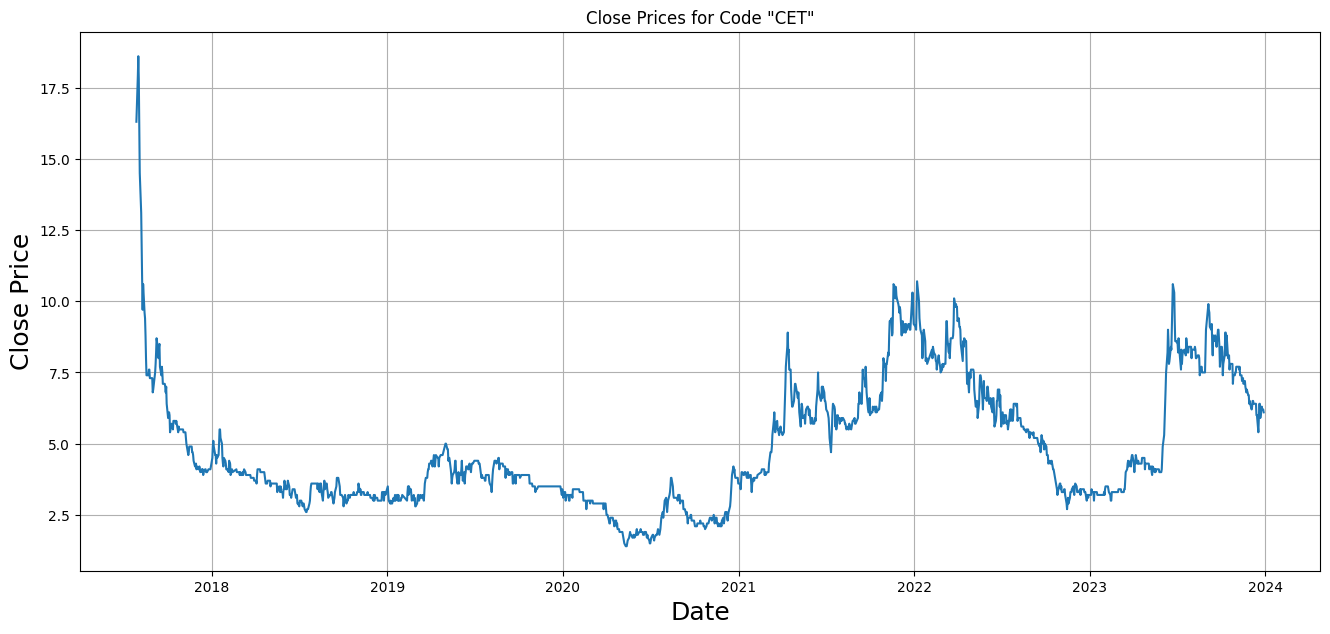

In [6]:
plt.figure(figsize=(16, 7))
plt.plot(df1['date'], df1['close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.title('Close Prices for Code "CET"')
plt.grid(True)
plt.show();

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

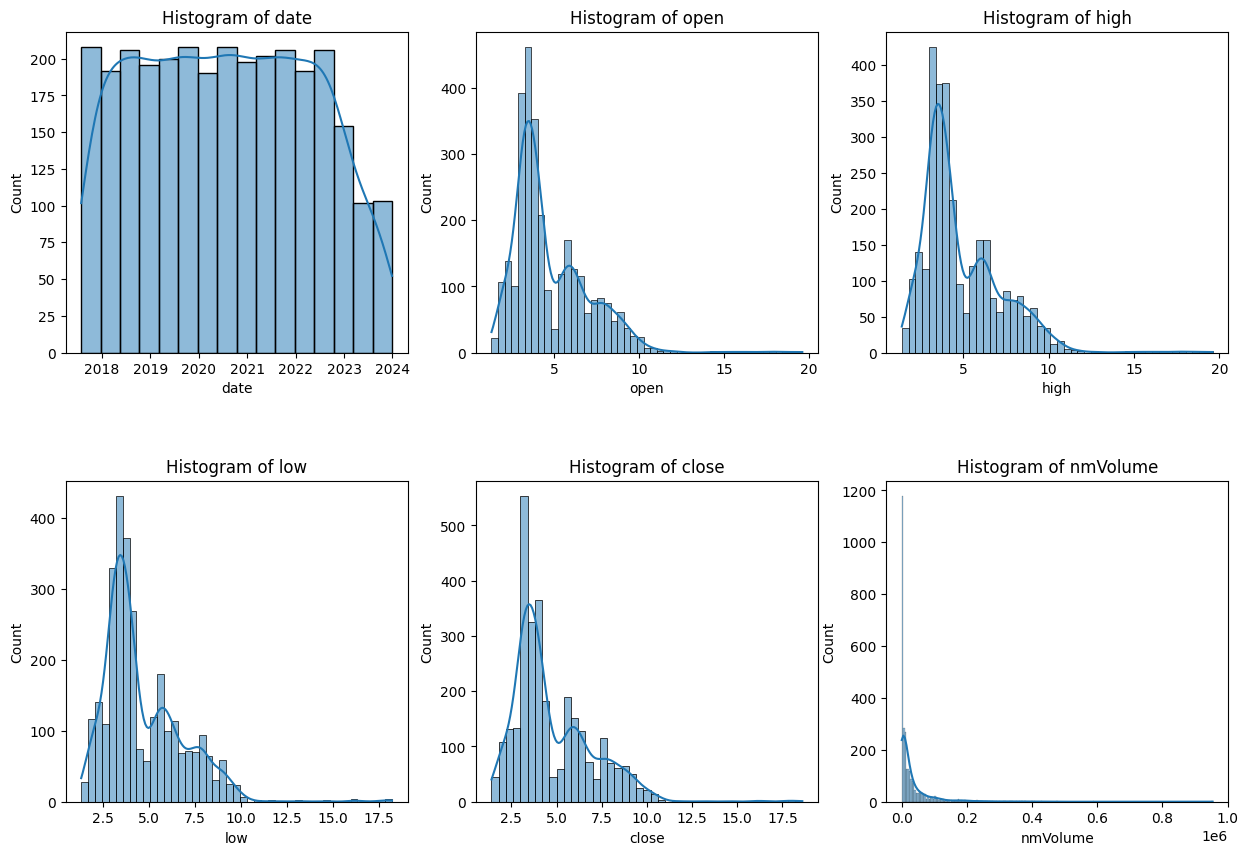

In [7]:
import seaborn as sns

plt.figure(figsize=(15, 10))
grid = plt.GridSpec(2, 3, hspace=0.4)

for i, col in enumerate(numerical_columns):
    plt.subplot(grid[i // 3, i % 3])
    
    sns.histplot(df1[col], kde=True)
    plt.title(f"Histogram of {col}")
    
plt.tight_layout()
plt.show();


In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1 = df1.set_index('date')
df1 = df1['close'].sort_index()
# df1 = df1['2022-01-01':'2023-12-31']

# TEST FOR STATIONARY
## Purpose:
- Linear regression models, as we know, work best when the predictors are not correlated and are independent of each other. So we need to make the time series stationary.

- Auto Regressive (AR) is a kind of linear where we use its own lags as a parameter for prediction

## Target:
d - if stationary, find d. Otherwise d=0

In [9]:
# use stats stest ad fuller to check for stationary
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(df1.dropna())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# p-value is not under 0.05 
# which means it's not stationary at this point of time

ADF Statistic: -6.098533
p-value: 0.000000


# AR using PACF 
- identify q
- Partial autocorrelation uses PACF is the correlation between the series and its lag, after excluding the contributions from the intermediate lags. Therefore, the PACF is the pure correlation between a lag and the series. 


In [10]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
        
check_stationarity(df1)


ADF Statistic: -6.098533
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Stationary


In [11]:
df2 = df1.diff()#d=1
df3 = df2.diff()#d=2

# **1. Introduction to ARIMA Models** <a class="anchor" id="2"></a>

[Table of Contents](#0.1)


- **ARIMA** stands for **Autoregressive Integrated Moving Average Model**. It belongs to a class of models that explains a given time series based on its own past values -i.e.- its own lags and the lagged forecast errors. The equation can be used to forecast future values. Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.


- So, **ARIMA**, short for **AutoRegressive Integrated Moving Average**, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.


- **ARIMA Models** are specified by three order parameters: (p, d, q), 

   where,

   - p is the order of the AR term

   - q is the order of the MA term

   - d is the number of differencing required to make the time series stationary


- **AR(p) Autoregression** – a regression model that utilizes the dependent relationship between a current observation and observations over a previous period. An auto regressive (AR(p)) component refers to the use of past values in the regression equation for the time series.


- **I(d) Integration** – uses differencing of observations (subtracting an observation from observation at the previous time step) in order to make the time series stationary. Differencing involves the subtraction of the current values of a series with its previous values d number of times.


- **MA(q) Moving Average** – a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. A moving average component depicts the error of the model as a combination of previous error terms. The order q represents the number of terms to be included in the model.




## **Types of ARIMA Model**


- **ARIMA** : Non-seasonal Autoregressive Integrated Moving Averages
- **SARIMA** : Seasonal ARIMA
- **SARIMAX** : Seasonal ARIMA with exogenous variables



If a time series, has seasonal patterns, then we need to add seasonal terms and it becomes SARIMA, short for **Seasonal ARIMA**.

# **2. The meaning of p, d and q in ARIMA model** <a class="anchor" id="3"></a>

[Table of Contents](#0.1)


## **3.1 The meaning of p**


- `p` is the order of the **Auto Regressive (AR)** term. It refers to the number of lags of Y to be used as predictors.



## **3.2 The meaning of d**


- The term **Auto Regressive**’ in ARIMA means it is a linear regression model that uses its own lags as predictors. Linear regression models, as we know, work best when the predictors are not correlated and are independent of each other. So we need to make the time series stationary.


- The most common approach to make the series stationary is to difference it. That is, subtract the previous value from the current value. Sometimes, depending on the complexity of the series, more than one differencing may be needed.


- The value of d, therefore, is the minimum number of differencing needed to make the series stationary. If the time series is already stationary, then d = 0.



## **3.3 The meaning of q**


- **q** is the order of the **Moving Average (MA)** term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

<Figure size 1200x600 with 0 Axes>

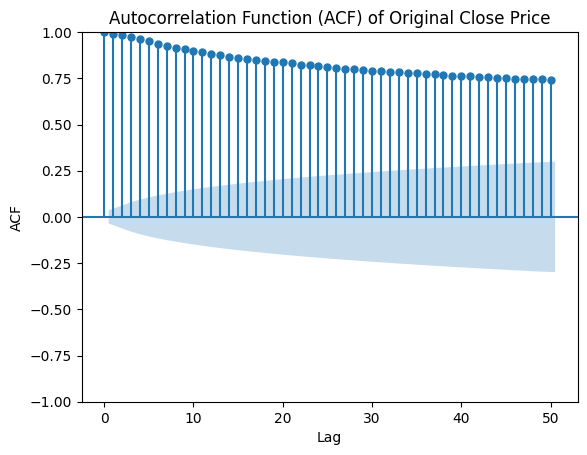

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot the ACF (Autocorrelation Function) of the original time series
plt.figure(figsize=(12, 6))
plot_acf(df1, lags=50)
plt.title('Autocorrelation Function (ACF) of Original Close Price')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

<Figure size 1200x600 with 0 Axes>

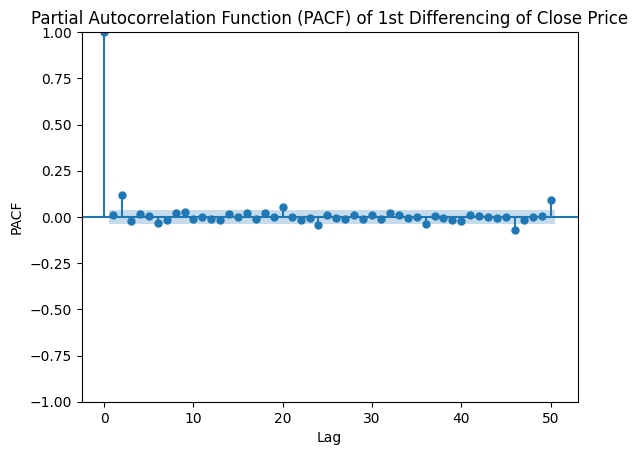

In [13]:
# Plot the PACF (Partial Autocorrelation Function) of the 1st differenced series
plt.figure(figsize=(12, 6))
plot_pacf(df1.diff().dropna(), lags=50)
plt.title('Partial Autocorrelation Function (PACF) of 1st Differencing of Close Price')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

In [14]:
# CHỌN THỦ CÔNG
# from statsmodels.tsa.arima_model import ARIMA

# # Differencing the data
# df1_diff = df1.diff().dropna()

# # Fitting the ARIMA model
# model = ARIMA(df1_diff.values, order=(1,1,2))
# model_fit = model.fit(disp=0)
# print(model_fit.summary())


## ARIMA Model Results                              

- **Dependent Variable:** D.y
- **No. Observations:** 2969
- **Model:** ARIMA(1, 1, 2)
- **Log Likelihood:** 662.093
- **Method:** css-mle
- **Date:** Mon, 19 Feb 2024
- **Time:** 03:02:43
- **Sample:** 1
- **AIC:** -1314.185
- **BIC:** -1284.205
- **HQIC:** -1303.396<br>

### Coefficients:

|              | Coefficient | Std Error |    z    | P > | z |   [0.025   |   0.975]   |<br>
|--------------|-------------|-----------|---------|----------|-------------|-------------|<br>
| const        | 2.241e-05   | 2.46e-05  | 0.911   | 0.363    | -2.58e-05   | 7.06e-05    |<br>
| ar.L1.D.y    | -0.7679     | 0.099     | -7.766  | 0.000    | -0.962      | -0.574      |<br>
| ma.L1.D.y    | -0.2650     | 0.105     | -2.513  | 0.012    | -0.472      | -0.058      |<br>
| ma.L2.D.y    | -0.7239     | 0.105     | -6.893  | 0.000    | -0.930      | -0.518      |<br>


### Roots:
- **AR.1:** -1.3022 (Real), 0.0000 (Imaginary), Modulus: 1.3022, Frequency: 0.5000
- **MA.1:** 1.0065 (Real), 0.0000 (Imaginary), Modulus: 1.0065, Frequency: 0.0000
- **MA.2:** -1.3725 (Real), 0.0000 (Imaginary), Modulus: 1.3725, Frequency: 0.5000


- The model summary provides lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.

- The coefficient of the MA2 term is close to zero and the P-Value in ‘P>|z|’ column is highly insignificant. It should ideally be less than 0.05 for the respective X to be significant.

- So, we will rebuild the model without the MA1 term.

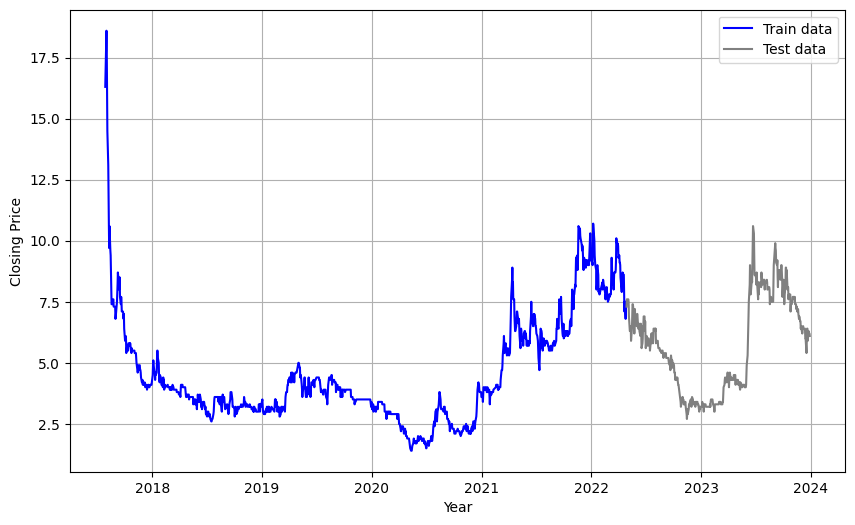

In [15]:
# split data into train and training set
Stock_data_arima = df1
train_test_split_ratio = int(len(Stock_data_arima)*0.8)
train_data, test_data = Stock_data_arima[:train_test_split_ratio], Stock_data_arima[train_test_split_ratio:]


# Plotting the train and test sets.
plt.figure(figsize=(10,6))
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.plot(train_data, 'blue', label='Train data')
plt.plot(test_data, 'gray', label='Test data')
plt.grid(True)
plt.legend()

In [16]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.1 MB/s eta 0:00:00a 0:00:01


In [17]:
# pip install pyramid-arima
import pmdarima as pm
smodel = pm.auto_arima(train_data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=25.87 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=5141.150, Time=0.40 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-491.671, Time=8.72 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2908.495, Time=7.05 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=5149.889, Time=0.19 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-16.848, Time=1.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-750.687, Time=25.91 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=55.82 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=19.63 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=5068.120, Time=6.37 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-749.024, Time=35.72 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=-748.938, Time=32.10 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=2908.622, Time=15.75 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=-755.776, Time=50.14 sec
 ARIMA(2,0,1)(1,1,0)[12] in

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 2376
Model:             SARIMAX(3, 0, 1)x(2, 1, [], 12)   Log Likelihood                 416.548
Date:                             Tue, 20 Feb 2024   AIC                           -819.096
Time:                                     16:18:32   BIC                           -778.719
Sample:                                          0   HQIC                          -804.396
                                            - 2376                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2257      0.077     15.875      0.000       1.074       1.377
ar.L2         -0.0725      0.080     -0.906      0.365      -0.229       0.084
ar.L3         -0.1754      0.012    -15.119      0.000      -0.198      -0.153
ma.L1         -0.2412      0.085     -2.852      0.004      -0.407      -0.075
ar.S.L12      -0.6362      0.009    -70.785      0.000      -0.654      -0.619
ar.S.L24      -0.3643      0.011    -33.744      0.000      -0.385      -0.343
sigma2         0.0410      0.000     91.904      0.000       0.040       0.042
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             34616.20
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                            -0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
# Forecast
n_periods = len(test_data)
alpha = 0.1 #95% CI
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True, alpha=alpha)


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [19]:
fitted_df = pd.DataFrame({'predicted_values': fitted.values}, index=test_data.index)
fitted_df['lower'] = confint[:, 0]
fitted_df['upper'] = confint[:, 1]
print(fitted_df)


            predicted_values     lower      upper
date                                             
2022-04-28          6.973653  6.640571   7.306736
2022-04-28          7.032016  6.564612   7.499420
2022-04-29          7.067739  6.466776   7.668703
2022-04-29          7.122120  6.410668   7.833572
2022-05-04          7.155766  6.348325   7.963206
...                      ...       ...        ...
2023-12-25          6.363172 -5.026756  17.753101
2023-12-26          6.430406 -4.971365  17.832177
2023-12-27          6.576457 -4.836571  17.989486
2023-12-28          6.637542 -4.786010  18.061094
2023-12-29          6.441452 -4.991887  17.874792

[595 rows x 3 columns]


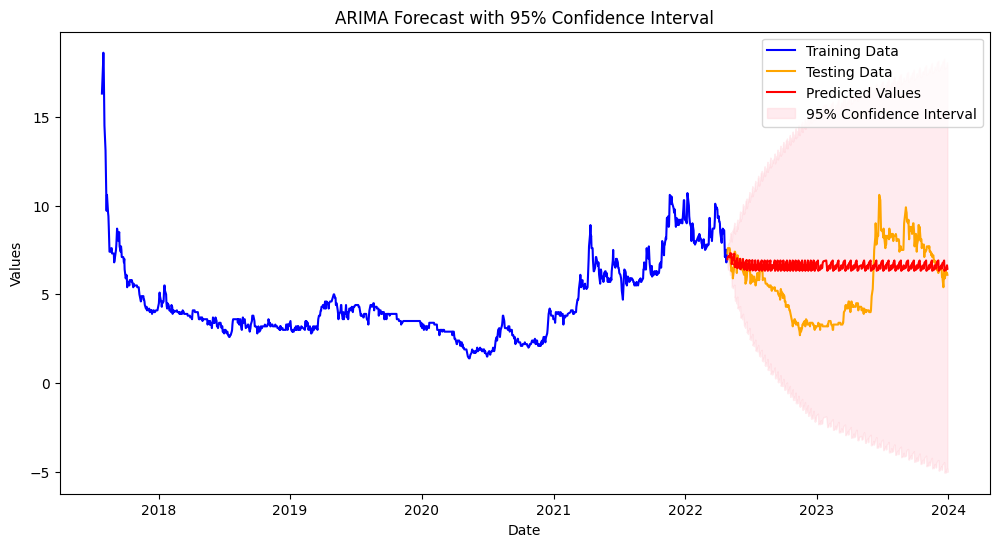

In [20]:
# Assuming fitted_df is your DataFrame with predicted values, lower, and upper bounds
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data', color='blue')
plt.plot(test_data, label='Testing Data', color='Orange')

plt.plot(fitted_df.index, fitted_df['predicted_values'], label='Predicted Values', color='red')
plt.fill_between(fitted_df.index, fitted_df['lower'], fitted_df['upper'], color='pink', alpha=0.3, label='95% Confidence Interval')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('ARIMA Forecast with 95% Confidence Interval')

# Show legend
plt.legend()

# Show the plot
plt.show()


In [21]:
# # Build Model
# # fitted = smodel.fit(disp=-1)  

# # Forecast
# fc, se, conf = fitted.forecast(119, alpha=0.05)  # 95% confidence interval

# # fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% confidence interval

# # Make as pandas series
# fc_series = pd.Series(fc, index=pd.date_range(start=test.index[0], periods=len(fc)))

# # Create DataFrame for predicted values and confidence intervals
# fitted_df = pd.DataFrame({'predicted_values': fc_series, 'lower': conf[:, 0], 'upper': conf[:, 1]}, index=fc_series.index)

# # Plot
# plt.figure(figsize=(10,6))
# plt.plot(train, label='training')
# plt.plot(test, label='actual')
# plt.plot(fc_series, label='forecast')
# plt.fill_between(fitted_df.index, fitted_df['lower'], fitted_df['upper'], color='pink', alpha=0.3, label='95% Confidence Interval')
# # Set labels and title
# plt.xlabel('Date')
# plt.ylabel('Values')
# plt.title('ARIMA Forecast with 95% Confidence Interval')

# # Show legend
# plt.legend()
# plt.grid(True)


# # Show the plot
# plt.show()


# Random forest

## Type1: một biến

In [22]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
df1 = df.copy()
df1 = df1[df1['code'] == 'CET']
numerical_columns = ['date', 'open', 'high', 'low', 'close','nmVolume']
df1 = df1.sort_values(by='date')
closedf = df1[['date','close']]
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='Stock close price chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()
closedf

,date,close
460516,2017-07-28,16.3
3857,2017-07-28,16.3
460515,2017-07-31,17.9
3856,2017-07-31,17.9
460514,2017-08-01,18.6
...,...,...
458911,2023-12-25,6.3
458910,2023-12-26,6.2
458909,2023-12-27,6.2
458908,2023-12-28,6.2


In [23]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler


close_stock = closedf.copy()
del closedf['date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)
training_size=int(len(closedf)*0.70)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

(2971, 1)
train_data:  (2079, 1)
test_data:  (892, 1)


In [25]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (2063, 15)
y_train:  (2063,)
X_test:  (876, 15)
y_test (876,)


## lấy time_step ngày dự đoán t ngày

In [26]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [27]:
train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (2063, 1)
Test data prediction: (876, 1)


In [28]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [29]:
# Evaluation metrices RMSE and MAE
import math
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  0.058054827988020495
Train data MSE:  0.0033703630527186475
Test data MAE:  0.03587127697901
-------------------------------------------------------------------------------------
Test data RMSE:  0.5500215332611179
Test data MSE:  0.30252368705091104
Test data MAE:  0.3367574472711457


In [30]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9984511965085208
Test data explained variance regression score: 0.9452275708480904


In [31]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle

# ! pip install plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

2024-02-20 16:18:40.621733: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 16:18:40.621927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 16:18:40.801125: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [32]:
look_back = 10
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print('train shape: ', train_predict.shape)

testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan

start_idx = len(train_predict) + (look_back * 2) + 1
end_idx = start_idx + len(test_predict)

testPredictPlot[start_idx:end_idx, :] = test_predict[:len(test_predict)]

print('test shape: ', test_predict[:len(test_predict)].shape)




train shape:  (2063, 1)
test shape:  (876, 1)


In [33]:
names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [34]:
original_ytest_df = pd.DataFrame(original_ytest, columns=['original_ytest'])
test_predict_df = pd.DataFrame(test_predict, columns=['test_predict'])
combined_df = pd.concat([original_ytest_df, test_predict_df], axis=1)
combined_df


,original_ytest,test_predict
0,6.1,5.908
1,6.1,6.029
2,6.1,6.078
3,6.1,6.067
4,6.1,6.044
...,...,...
871,5.9,6.464
872,6.3,5.861
873,6.2,6.286
874,6.2,6.118


## Type 2: đa biến

In [35]:
df2 = df.copy()
df2 = df2[df2['code'] == 'CET']
numerical_columns = ['date', 'open', 'high', 'low', 'close','nmVolume']
df2['date'] = pd.to_datetime(df2['date'])
df2 = df2.set_index('date')
df2 = df2.sort_values(by='date')


In [36]:
df2

,code,open,high,low,close,adClose,nmVolume,nmValue
date,,,,,,,,
2017-07-28,CET,16.3,16.3,16.3,16.3,14.818,68000,1.108400e+09
2017-07-28,CET,16.3,16.3,16.3,16.3,14.818,68000,1.108400e+09
2017-07-31,CET,17.9,17.9,17.9,17.9,16.273,124400,2.226760e+09
2017-07-31,CET,17.9,17.9,17.9,17.9,16.273,124400,2.226760e+09
2017-08-01,CET,19.6,19.6,18.2,18.6,16.909,93200,1.753470e+09
...,...,...,...,...,...,...,...,...
2023-12-25,CET,6.0,6.3,6.0,6.3,6.300,500,3.030000e+06
2023-12-26,CET,6.1,6.2,6.1,6.2,6.200,400,2.470000e+06
2023-12-27,CET,6.2,6.2,6.2,6.2,6.200,0,0.000000e+00


In [37]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df2, test_size=0.2, shuffle=False)


In [39]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

tscv = TimeSeriesSplit(n_splits=5)
predictors = ["nmVolume", "open", "high", "low"]
target = "close"
param_grid = {
    'n_estimators': [100, 200, 300],
    'min_samples_split': [50, 100, 150]
}

# Initialize the RandomForestRegressor
model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object
grid_search.fit(train[predictors], train[target])

best_params = grid_search.best_params_
print("Best parameters:", best_params)
best_model = grid_search.best_estimator_

test_predictions = best_model.predict(test[predictors])

mse = mean_squared_error(test[target], test_predictions)
print("Mean Squared Error:", mse)


Best parameters: {'min_samples_split': 50, 'n_estimators': 200}
Mean Squared Error: 0.03175546853397909


In [40]:
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestRegressor


# Create and fit the RandomForestRegressor
model = RandomForestRegressor(n_estimators=200, min_samples_split=50, random_state=42) 
model.fit(train[predictors], train[target])


RandomForestRegressor(min_samples_split=50, n_estimators=200, random_state=42)

In [41]:
def predict(train, test, predictors, model):
    # Train the model on the training data
    model.fit(train[predictors], train[target])

    # Make predictions on the testing data
    preds = model.predict(test[predictors])

    preds = pd.Series(preds, index=test.index, name="predictions")

    # Combine the actual target values and predicted values into a DataFrame
    combined = pd.concat([test[target], preds], axis=1)
    return combined


In [42]:
# Đây là quá trình đánh giá hiệu suất của một chiến lược giao dịch bằng cách áp dụng nó cho history data
def backtest(data, model, predictors, start = 2500, step = 250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        predictions = predict(train, test, predictors, model)
        
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [43]:
predictions = backtest(df2, model, predictors)
predictions

,close,predictions
date,,
2022-07-27,6.4,6.424132
2022-07-27,6.4,6.424132
2022-07-28,6.4,6.357913
2022-07-28,6.4,6.357913
2022-07-29,6.4,6.185789
...,...,...
2023-12-25,6.3,6.116363
2023-12-26,6.2,6.116302
2023-12-27,6.2,6.215348


In [44]:
import plotly.graph_objects as go
trace1 = go.Scatter(x=df2.index, y=df2['close'], mode='lines', name='Actual Close')
trace2 = go.Scatter(x=predictions.index, y=predictions['predictions'], mode='lines', name='Predicted Close')

# Create figure
fig = go.Figure()

# Add traces
fig.add_trace(trace1)
fig.add_trace(trace2)

# Update layout
fig.update_layout(
    title='Actual vs. Predicted Close Price',
    xaxis_title='Date',
    yaxis_title='Close Price',
    hovermode='x'
)

# Show plot
fig.show()


In [45]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, precision_score, recall_score

# # Assume df contains the necessary data including 'close', '42d', and '252d' columns

# # Define the thresholds to be tested
# thresholds = [0.1, 0.5, 1.0, 1.5]

# # Define predictors and target
# predictors = ["nmVolume", "open", "high", "low"]
# target = "close"

# # Split data into train and test sets
# train, test = train_test_split(df2, test_size=0.2, shuffle=False)

# # Initialize variables to store the best threshold and corresponding performance
# best_threshold = None
# best_performance = 0

# df = df2[['close']]
# tmp_42d =df2[['close']].rolling(window=42).mean()
# tmp_252d = df2[['close']].rolling(window=252).mean()
# df['42d'] = tmp_42d
# df['252d'] = tmp_252d

# # Iterate over thresholds
# for threshold in thresholds:
#     # Calculate signals based on the threshold
#     df2['delta'] = df['42d'] - df['252d']
#     df2['signal'] = np.where(df2['delta'] > threshold, 1, 0)
#     df2['signal'] = np.where(df2['delta'] < -threshold, -1, df2['signal'])
    
#     # Perform backtesting and evaluate performance
#     predictions = backtest(df, model, predictors)
    
#     # Calculate performance metrics
#     # For example, you can use accuracy_score, precision_score, recall_score, etc.
#     accuracy = accuracy_score(predictions[target], predictions['predictions'])
#     precision = precision_score(predictions[target], predictions['predictions'])
#     recall = recall_score(predictions[target], predictions['predictions'])
    
#     # Calculate a composite performance metric (e.g., average of accuracy, precision, recall)
#     performance = (accuracy + precision + recall) / 3
    
#     # Update the best performance and threshold if necessary
#     if performance > best_performance:
#         best_performance = performance
#         best_threshold = threshold

# # Print the best threshold and corresponding performance
# print("Best Threshold:", best_threshold)
# print("Best Performance:", best_performance)


/tmp/ipykernel_33/3075889617.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_33/3075889617.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



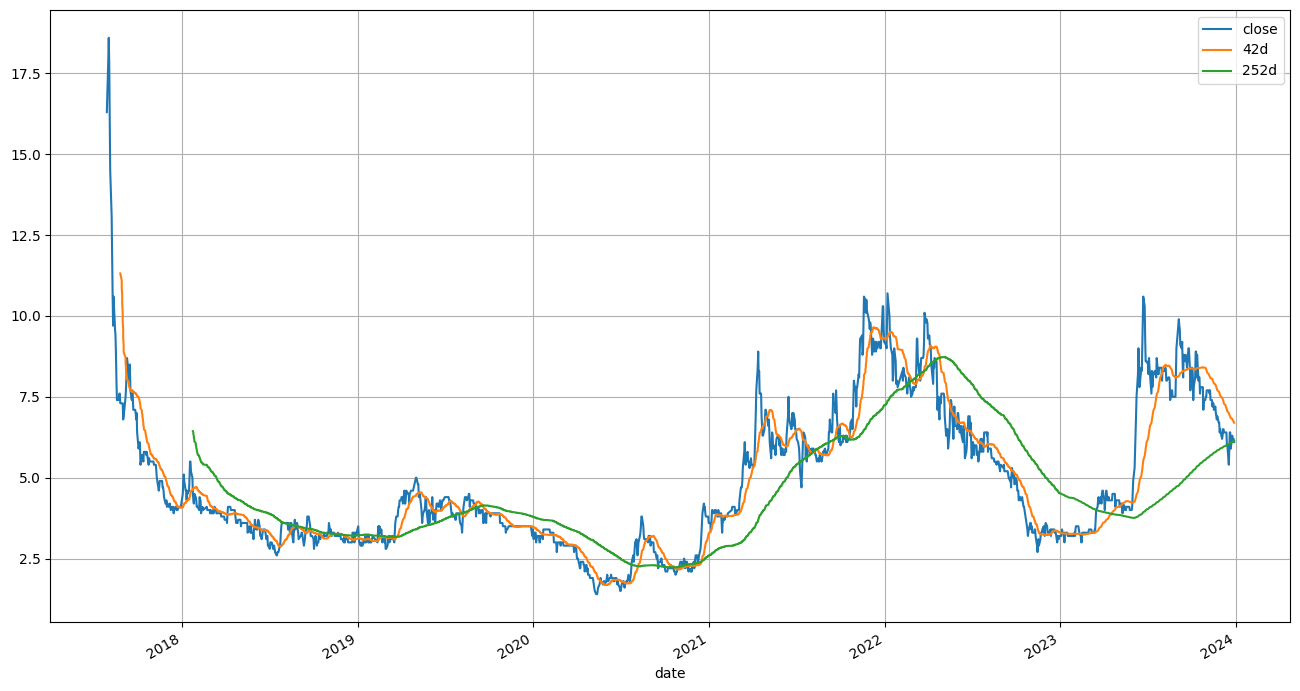

In [46]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
df = df2[['close']]
tmp_42d =df2[['close']].rolling(window=42).mean()
tmp_252d = df2[['close']].rolling(window=252).mean()
df['42d'] = tmp_42d
df['252d'] = tmp_252d
df.plot(grid=True, figsize=(16, 9), ax=ax);


In [47]:
# delta
signal_threshold = 0.5
df['delta'] = df['42d'] - df['252d']
df['signal'] = np.where(df['delta'] > signal_threshold, 1, 0)
df['signal'] = np.where(df['delta'] < -signal_threshold, -1, df['signal'])
df['signal'].value_counts()
#3084 days the 42d more than threshold and above the 252d
# 1222 days the 42d is more than threshold and below the 252d
# 1482 rest
# obviously, if short trend cross long trend, it will rest there for a while

/tmp/ipykernel_33/3382280217.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_33/3382280217.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_33/3382280217.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



signal
 0    1503
-1     772
 1     696
Name: count, dtype: int64

/tmp/ipykernel_33/1393692572.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_33/1393692572.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='date'>

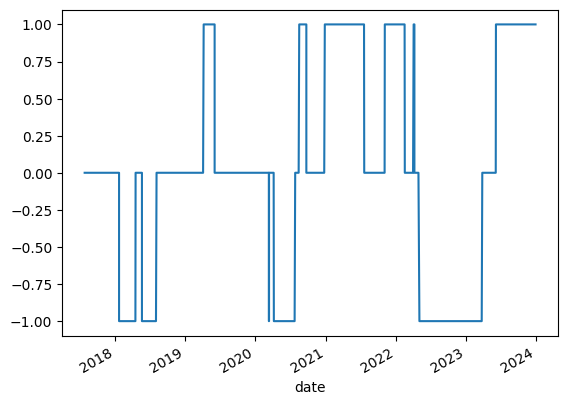

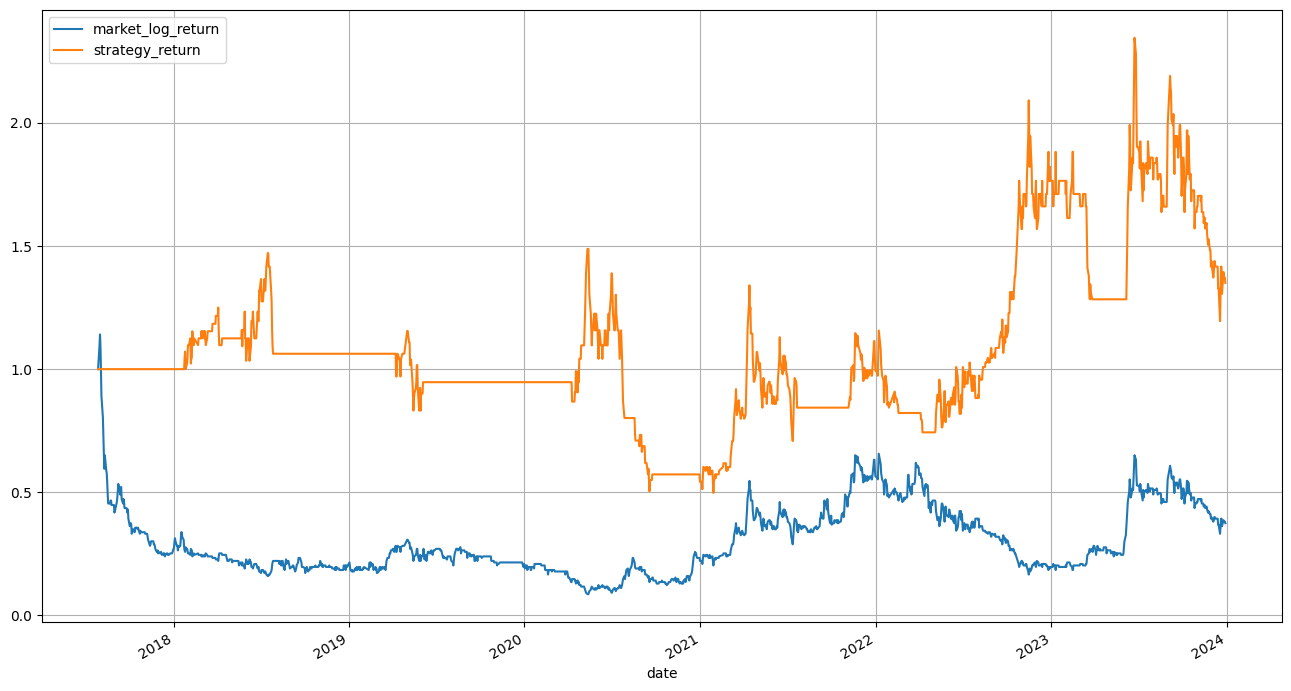

In [48]:
df['signal'].plot(lw=1.5)
# calc log return
df['market_log_return'] = np.log(df['close']/df['close'].shift(1))
df['strategy_return'] = df['signal'].shift(1) * df['market_log_return']

# np.exp helps to convert log return back to simple return
df[['market_log_return', 'strategy_return']].cumsum().apply(np.exp).plot(grid=True, figsize=(16, 9))
# read-more on log return here
# https://www.allquant.co/post/magic-of-log-returns-concept-part-1

#
# signal = 0 : no gain - park the cash
# signal = 1: gain if invest
# signal = -1: loss if invest

# we assume investor can directly invest into the index or can directly short the index
# which can be accomplished by using index funded.


In [49]:
df

,close,42d,252d,delta,signal,market_log_return,strategy_return
date,,,,,,,
2017-07-28,16.3,NaN,NaN,NaN,0,NaN,NaN
2017-07-28,16.3,NaN,NaN,NaN,0,0.000000,0.000000
2017-07-31,17.9,NaN,NaN,NaN,0,0.093636,0.000000
2017-07-31,17.9,NaN,NaN,NaN,0,0.000000,0.000000
2017-08-01,18.6,NaN,NaN,NaN,0,0.038361,0.000000
...,...,...,...,...,...,...,...
2023-12-25,6.3,6.821429,6.095238,0.726190,1,0.065597,0.065597
2023-12-26,6.2,6.792857,6.107143,0.685714,1,-0.016000,-0.016000
2023-12-27,6.2,6.764286,6.119048,0.645238,1,0.000000,0.000000
